In [1]:
import numpy as np
import math
import scipy.special as sci
from matplotlib import pyplot as plt

Name_plot = 114947
type = 'Bounded reservoir'
model_DCA = 'Power-law Bessel'
test_type = 'DCA'
fluid_type = 'gas'
#EMPIRICAL MATCHING PARAMETERS
qi_match = 1.59849291e+04 
a_match = 6.66395025e-01 
n_match = 2.15244930e-01 

#FOR POWER-LAW EXP (for comparision)
qi_Power_Exp_match = 3.96929961e+04
Di_Power_Exp_match = 1.27511638e+00
D_inf_Power_Exp_match = 0
n_Power_Exp_match = 1.73060553e-01

#import dataset from xlsx
import xlrd
#import col 0: shut-in time (t) in daya
#import col 1: rate data (STB/D)

N_data = 698
res_Excel = xlrd.open_workbook('Python_welltest_114947_Input.xlsx')
L_smooth = 0.6


# read pressure form Excel file
if test_type == 'DCA':  
    t = np.zeros((N_data,1))  #import time in Days
    qg = np.zeros((N_data,1)) 
    
    D_function = np.zeros((N_data,1))
    loss_ratio = np.zeros((N_data,1))
    b_function = np.zeros((N_data,1))
    
    for i in range (0,N_data):
        t[i] = res_Excel.sheet_by_name('rate').cell(i,0).value
        qg[i] = res_Excel.sheet_by_name('rate').cell(i,1).value
        
        #read provided D and b function
        D_function[i] = res_Excel.sheet_by_name('Db(provided)').cell(i,0).value
        b_function[i] = res_Excel.sheet_by_name('Db(provided)').cell(i,1).value
    
    #Rate-intergral and cumulative prouction calculation
    qg_i = np.zeros((N_data,1))
    Gp = np.zeros((N_data,1))
    
    sum_qg_i = 0
    for i in range (0,N_data):
        if i == 0:
            #sum_qg_i += (qg[i]+0)*(t[i]-0)/2  #Use Powerlaw Integral for first panel
            B_power_int = np.log(qg[i+1]/qg[i])/np.log(t[i+1]/t[i])
            A_power_int = qg[i]/t[i]**B_power_int
            sum_qg_i = A_power_int/(B_power_int+1)*t[i]**(B_power_int+1)
        else:
            sum_qg_i += (qg[i]+qg[i-1])*(t[i]-t[i-1])/2
          
        Gp[i] = sum_qg_i
        qg_i[i] = sum_qg_i/t[i]
            
    qg_id = np.zeros((N_data,1))
    qg_id = qg_i - qg

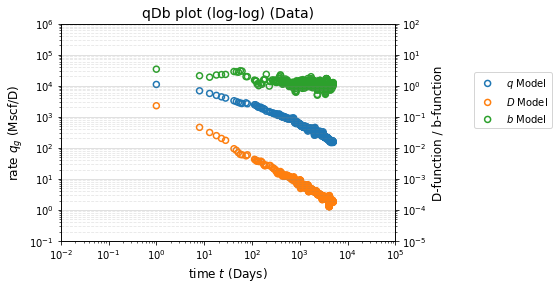

In [2]:
#DATA PLOT FOR DCA (DCA-1 PLOT 1)

DCA_1_1_plot = plt.figure()
ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5,label = r'$q$' +' Model')
ax2.scatter(t,D_function,facecolors='none', edgecolors='C1',linewidth=1.5,label = r'$D$' +' Model')
ax2.scatter(t,b_function,facecolors='none', edgecolors='C2',linewidth=1.5,label = r'$b$' +' Model')
#ax.scatter(t,Np,facecolors='none', edgecolors='C3',linewidth=1.5)

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

plt.title('qDb plot (log-log) (Data)',fontsize = 14)

#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 1e+5, 1e-1, 1e+6])
ax2.xaxis.set_major_locator(locmaj)
ax2.axis([1e-2, 1e+5, 1e-5, 1e+2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
#DCA_1_1_plot.savefig(str(Name_plot)+'_loglog_qDb_Data.png', dpi=500,bbox_inches = "tight")

In [3]:
#calculation of rate-time function (model)
#Note that return array always has the dimension of 100
import scipy.integrate as integrate

def q_Arps_exp(t,qi,Di):
    return qi*np.exp(-Di*t)

def q_Arps_hyperbolic(t,qi,Di,b):
    return qi/(1+b*Di*t)**(1/b)

def q_Arps_harmonic(t,qi,Di):
    return qi/(1+Di*t)

def q_Arps_modified_hyperbolic(t,qi,Di,b,Di_limit):
    t_limit = (Di/Di_limit-1)*1/b/Di
    return_array = np.zeros((len(t),1))
    
    for i in range(0,len(t)):
        if t[i] < t_limit:
            return_array[i] = qi/(1+b*Di*t[i])**(1/b)
        else:
            q_limit = qi/(1+b*Di*t_limit)**(1/b)
            return_array[i] = q_limit*np.exp(-Di_limit*(t[i]-t_limit))
            
    return return_array

def q_Power_Law_Exp(t,qi,Di,D_inf,n):
    return qi*np.exp(-D_inf*t-Di*t**n)

def q_Duong(t,qi,a,m):
    return qi*t**(-m)*np.exp(a/(1-m)*(t**(1-m)-1))

def q_Logistic(t,a,n,K):
    return a*K*n*t**(n-1)/(a+t**n)**2

def q_Weibull(t,M,gamma,alpha):
    return M*gamma/alpha*(t/alpha)**(gamma-1)*np.exp(-(t/alpha)**gamma)

def q_Power_Law_Bessel(t,qi,a,n):
    return qi*sci.k0(a*t**n)

#calculation of D-function (model)

def D_function_Arps_exp(t,qi,Di):
    return Di

def D_function_Arps_hyperbolic(t,qi,Di,b):
    return Di/(1+b*Di*t)

def D_function_Arps_harmonic(t,qi,Di):
    return Di/(1+Di*t)

def D_function_Arps_modified_hyperbolic(t,qi,Di,b,Di_limit):
    
    t_limit = (Di/Di_limit-1)*1/b/Di
    return_array = np.zeros((len(t),1))
    
    for i in range(0,len(t)):
        if t[i] < t_limit:
            return_array[i] = Di/(1+b*Di*t[i])
        else:
            return_array[i] = Di_limit
    return return_array
 
def D_function_Power_Law_Exp(t,qi,Di,D_inf,n):
    return D_inf + n*Di*t**(n-1)

def D_function_Duong(t,qi,a,m):
    return m/t - a*t**(-m)

def D_function_Logistic(t,a,n,K):
    return (1-n*(2*a/(a+t**n)-1))/t

def D_function_Weibull(t,M,gamma,alpha):
    return (gamma*(t/alpha)**gamma - (gamma-1))/t

def D_function_Power_Law_Bessel(t,qi,a,n):
    return a*n*t**(n-1)*sci.k1(a*t**n)/sci.k0(a*t**n)
    
#calculation of b-function (model)

def b_function_Arps_exp(t,qi,Di):
    return 0

def b_function_Arps_hyperbolic(t,qi,Di,b):
    return b*t/t

def b_function_Arps_harmonic(t,qi,Di):
    return 1

def b_function_Arps_modified_hyperbolic(t,qi,Di,b,Di_limit):
    
    t_limit = (Di/Di_limit-1)*1/b/Di
    return_array = np.zeros((len(t),1))
    
    for i in range(0,len(t)):
        if t[i] < t_limit:
            return_array[i] = b
        else:
            return_array[i] = 0
    return return_array

def b_function_Power_Law_Exp(t,qi,Di,D_inf,n):
    return n*(1-n)*Di*t**(-n)/(n*Di + D_inf*t**(1-n))**2

def b_function_Duong(t,qi,a,m):
    return (t**m-a*t)*m*(t**m)/(a*t-m*t**m)**2

def b_function_Logistic(t,a,n,K):
    term_1 = 1/(1-n*(2*a/(a+t**n)-1))
    term_2 = 2*a*n**2*t**n/(a+t**n)**2/(1-n*(2*a/(a+t**n)-1))**2
    return term_1 + term_2

def b_function_Weibull(t,M,gamma,alpha):
    return (1-gamma)*(gamma*(t/alpha)**gamma+1)/(gamma*((t/alpha)*gamma-1)+1)**2

def b_function_Power_Law_Bessel(t,qi,a,n):
    return (sci.k0(a*t**n)/sci.k1(a*t**n))**2 + t**(-n)*sci.k0(a*t**n)/a/n/sci.k1(a*t**n)-1

#calculation of Gp
def Gp_Arps_exp(t,qi,Di):
    return qi/Di*(1-np.exp(-Di*t))

def Gp_Arps_hyperbolic(t,qi,Di,b):
    return qi/Di/(1-b)*(1-1/(1+b*Di*t)**(1/b-1))

def Gp_Arps_harmonic(t,qi,Di):
    return qi/Di*np.log(1+Di*t)

def Gp_Arps_modified_hyperbolic(t,qi,Di,b,Di_limit):
    t_limit = (Di/Di_limit-1)*1/b/Di
    return_array = np.zeros((len(t),1))
    
    for i in range(0,len(t)):
        if t[i] < t_limit:
            return_array[i] = qi/Di/(1-b)*(1-1/(1+b*Di*t[i])**(1/b-1))
        else:
            q_limit = qi/(1+b*Di*t_limit)**(1/b)
            return_array[i] = qi/Di/(1-b)*(1-1/(1+b*Di*t_limit)**(1/b-1)) + q_limit/Di_limit*(1-np.exp(-Di_limit*(t[i]-t_limit)))
           
    return return_array

def Gp_Power_Law_Exp(t,qi,Di,D_inf,n):
    return_array = np.zeros((len(t),1))
    for i in range(0,len(t)):
         return_array[i] = integrate.quad(lambda tt: q_Power_Law_Exp(tt,qi,Di,D_inf,n), 0, t[i])[0]    
    
    return return_array

def Gp_Duong(t,qi,a,m):
    return_array = np.zeros((len(t),1))
    for i in range(0,len(t)):
         return_array[i] = integrate.quad(lambda tt: q_Duong(tt,qi,a,m), 0, t[i])[0]    
    
    return return_array

def Gp_Logistic(t,a,n,K):
    return_array = np.zeros((len(t),1))
    for i in range(0,len(t)):
         return_array[i] = integrate.quad(lambda tt: q_Logistic(tt,a,n,K), 0, t[i])[0]    
    
    return return_array

def Gp_Weibull(t,M,gamma,alpha):
    return_array = np.zeros((len(t),1))
    for i in range(0,len(t)):
         return_array[i] = integrate.quad(lambda tt: q_Weibull(tt,M,gamma,alpha), 0, t[i])[0]    
    
    return return_array


def Gp_Power_Law_Bessel(t,qi,a,n):
    return_array = np.zeros((len(t),1))
    for i in range(0,len(t)):
         return_array[i] = integrate.quad(lambda tt: q_Power_Law_Bessel(tt,qi,a,n), 0, t[i])[0]    
    
    return return_array

t_mod = np.logspace(-2,5,100)
qg_mod = q_Power_Law_Bessel(t_mod,qi_match,a_match,n_match)
D_function_mod = D_function_Power_Law_Bessel(t_mod,qi_match,a_match,n_match)
b_function_mod = b_function_Power_Law_Bessel(t_mod,qi_match,a_match,n_match)
Gp_mod = Gp_Power_Law_Bessel(t_mod,qi_match,a_match,n_match)

qg_Power_Exp_mod = q_Power_Law_Exp(t_mod,qi_Power_Exp_match,Di_Power_Exp_match,D_inf_Power_Exp_match,n_Power_Exp_match)
D_function_Power_Exp_mod = D_function_Power_Law_Exp(t_mod,qi_Power_Exp_match,Di_Power_Exp_match,D_inf_Power_Exp_match,n_Power_Exp_match)
b_function_Power_Exp_mod = b_function_Power_Law_Exp(t_mod,qi_Power_Exp_match,Di_Power_Exp_match,D_inf_Power_Exp_match,n_Power_Exp_match)
Gp_Power_Exp_mod = Gp_Power_Law_Exp(t_mod,qi_Power_Exp_match,Di_Power_Exp_match,D_inf_Power_Exp_match,n_Power_Exp_match)

#print(Gp_mod)

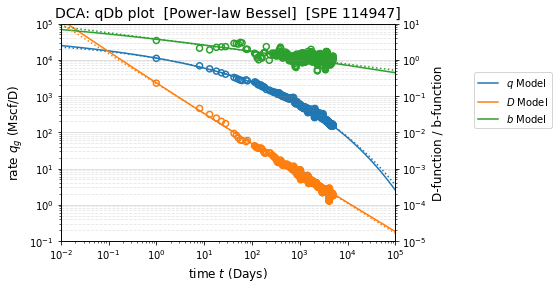

In [4]:
#qDb LOG_LOG PLOT

qDb_plot = plt.figure()

#overlay: plotting qDb plot for raw data
ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)
ax2.scatter(t,D_function,facecolors='none', edgecolors='C1',linewidth=1.5)
ax2.scatter(t,b_function,facecolors='none', edgecolors='C2',linewidth=1.5)

ax.loglog(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')
ax2.loglog(t_mod,D_function_mod,color='C1',label = r'$D$' +' Model')
ax2.loglog(t_mod,b_function_mod,color='C2',label = r'$b$' +' Model')

ax.loglog(t_mod,qg_Power_Exp_mod,':',color='C0')
ax2.loglog(t_mod,D_function_Power_Exp_mod,':',color='C1')
ax2.loglog(t_mod,b_function_Power_Exp_mod,':',color='C2')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

plt.title('DCA: qDb plot  ['+str(model_DCA)+']  [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 1e+5, 1e-1, 1e+5])
ax2.xaxis.set_major_locator(locmaj)
ax2.axis([1e-2, 1e+5, 1e-5, 1e+1])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
qDb_plot.savefig(str(Name_plot)+'_qDb (' + str(model_DCA)+').png', dpi=500,bbox_inches = "tight")

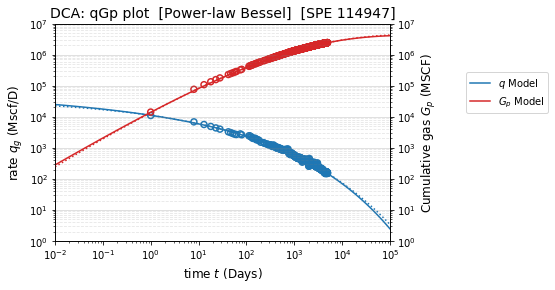

In [5]:
#qGp LOG-LOG PLOT

qGp_plot = plt.figure()

#overlay: plotting qDb plot for raw data
ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)
ax2.scatter(t,Gp,facecolors='none', edgecolors='C3',linewidth=1.5)

ax.loglog(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')
ax2.loglog(t_mod,Gp_mod,color='C3',label = r'$G_{p}$' +' Model')

ax.loglog(t_mod,qg_Power_Exp_mod,':',color='C0')
ax2.loglog(t_mod,Gp_Power_Exp_mod,':',color='C3')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

plt.title('DCA: qGp plot  ['+str(model_DCA)+']  [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)
#ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1) for legend positon

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
    ax2.set_ylabel('Cumulative gas ' + r'$G_{p}$' + ' (MSCF)',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)
    ax2.set_ylabel('Cumulative oil ' + r'$N_{p}$' + ' (STB)',fontsize = 12)
    

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 1e+5, 1e+0, 1e+7])
ax2.xaxis.set_major_locator(locmaj)
ax2.axis([1e-2, 1e+5, 1e+0, 1e+7])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
qGp_plot.savefig(str(Name_plot)+'_qGp (' + str(model_DCA)+').png', dpi=500,bbox_inches = "tight")

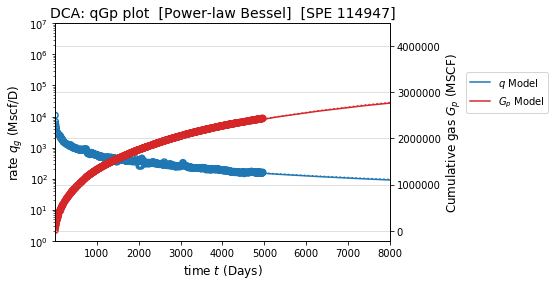

In [6]:
#qGp SEMI-LOG PLOT (Np-augmented)

qGp_semilog_plot = plt.figure()

#overlay: plotting qDb plot for raw data
ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)
ax2.scatter(t,Gp,facecolors='none', edgecolors='C3',linewidth=1.5)

ax.plot(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')
ax2.plot(t_mod,Gp_mod,color='C3',label = r'$G_{p}$' +' Model')

ax.plot(t_mod,qg_Power_Exp_mod,':',color='C0')
ax2.plot(t_mod,Gp_Power_Exp_mod,':',color='C3')

#ax.set_xscale('log')
#ax2.set_xscale('log')
ax.set_yscale('log')
#ax2.set_yscale('log')

plt.title('DCA: qGp plot  ['+str(model_DCA)+']  [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)
#ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1) for legend positon

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
    ax2.set_ylabel('Cumulative gas ' + r'$G_{p}$' + ' (MSCF)',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)
    ax2.set_ylabel('Cumulative oil ' + r'$N_{p}$' + ' (STB)',fontsize = 12)
    

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 

ax.axis([1e-2, 8e+3, 1e+0, 1e+7])

plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
qGp_semilog_plot.savefig(str(Name_plot)+'_qGp_semilog (' + str(model_DCA)+').png', dpi=500,bbox_inches = "tight")

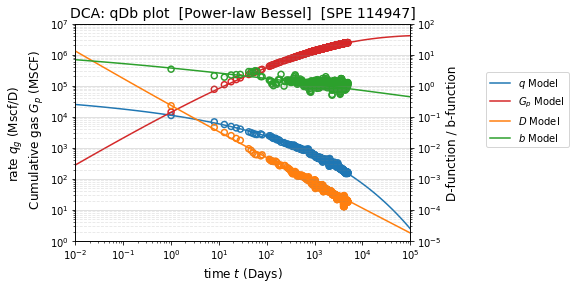

In [7]:
#qDb LOG_LOG PLOT (Gp-augmented)

qDb_Gp_plot = plt.figure()

#overlay: plotting qDb plot for raw data
ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)
ax2.scatter(t,D_function,facecolors='none', edgecolors='C1',linewidth=1.5)
ax2.scatter(t,b_function,facecolors='none', edgecolors='C2',linewidth=1.5)
ax.scatter(t,Gp,facecolors='none', edgecolors='C3',linewidth=1.5)

ax.loglog(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')
ax2.loglog(t_mod,D_function_mod,color='C1',label = r'$D$' +' Model')
ax2.loglog(t_mod,b_function_mod,color='C2',label = r'$b$' +' Model')
ax.loglog(t_mod,Gp_mod,color='C3',label = r'$G_{p}$' +' Model')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

plt.title('DCA: qDb plot  ['+str(model_DCA)+']  [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)
#ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1) for legend positon

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)'+' \n  Cumulative gas ' + r'$G_{p}$' + ' (MSCF)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)'+' \n  Cumulative oil ' + r'$N_{p}$' + ' (STB)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)
    

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 1e+5, 1e+0, 1e+7])
ax2.xaxis.set_major_locator(locmaj)
ax2.axis([1e-2, 1e+5, 1e-5, 1e+2])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
qDb_Gp_plot.savefig(str(Name_plot)+'_qDb_Gp (' + str(model_DCA)+').png', dpi=500,bbox_inches = "tight")

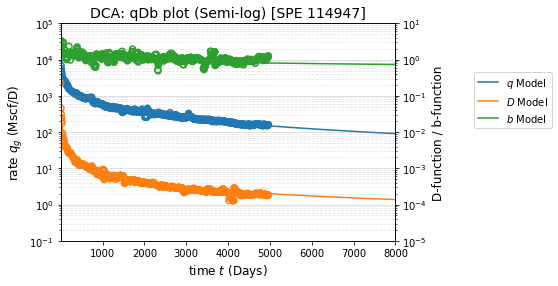

In [8]:
#qDb SEMILOG plot

qDb_semilog_plot = plt.figure()

ax = plt.gca()
#ax.set_aspect('equal')
ax2 = ax.twinx()

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)
ax2.scatter(t,D_function,facecolors='none', edgecolors='C1',linewidth=1.5)
ax2.scatter(t,b_function,facecolors='none', edgecolors='C2',linewidth=1.5)

ax.plot(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')
ax2.plot(t_mod,D_function_mod,color='C1',label = r'$D$' +' Model')
ax2.plot(t_mod,b_function_mod,color='C2',label = r'$b$' +' Model')

#ax.set_xscale('log')
#ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

plt.title('DCA: qDb plot (Semi-log) [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)
ax.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(1.35, 0.8), ncol=1)

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)
    ax2.set_ylabel('D-function / b-function',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
#ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 8e+3, 1e-1, 1e+5])
#ax2.xaxis.set_major_locator(locmaj)
ax2.axis([1e-2, 8e+3, 1e-5, 1e+1])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
#qDb_semilog_plot.savefig(str(Name_plot)+'_qDb_semilog (' + str(model_DCA)+').png', dpi=500,bbox_inches = "tight")

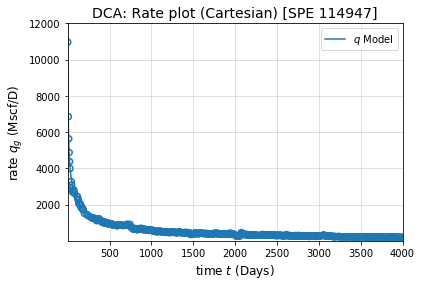

In [9]:
#CARTESIAN PLOT

Cartesian_plot = plt.figure()

ax = plt.gca()
#ax.set_aspect('equal')

ax.scatter(t,qg,facecolors='none', edgecolors='C0',linewidth=1.5)

ax.plot(t_mod,qg_mod,color='C0',label = r'$q$' +' Model')

#ax.set_xscale('log')
#ax.set_yscale('log')

plt.title('DCA: Rate plot (Cartesian) [SPE '+str(Name_plot)+']',fontsize = 14)
#adding legends
plt.legend()

if fluid_type == 'gas':
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{g}$'+ ' (Mscf/D)',fontsize = 12)
else:
    ax.set_xlabel('time ' + r'$t$' + ' (Days)',fontsize = 12)
    ax.set_ylabel('rate ' + r'$q_{o}$'+ ' (STB/D)',fontsize = 12)

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=14) 
#ax.xaxis.set_major_locator(locmaj)
ax.axis([1e-2, 4e+3, 1e-1, 1.2e+4])
plt.grid(b=True, which='major', color=(0.5,0.5,0.5), alpha = 0.3, linestyle='-')
plt.grid(b=True, which='minor', color=(0.5,0.5,0.5), alpha = 0.2, linestyle='--')
#Cartesian_plot.savefig(str(Name_plot)+'_Cartesian (' + str(model_DCA)+').png', dpi=500)

In [10]:
#CURVE-FIT BOX
from scipy.optimize import curve_fit
Opt_matrix = np.zeros((N_data,2))

for i in range (0,N_data):
   
    Opt_matrix[i,0] = t[i]
    Opt_matrix[i,1] = qg[i]

xdata = np.array(Opt_matrix[:,0])
ydata = np.array(Opt_matrix[:,1])

initial_guess = [16000,0.65,0.2] 
bound = [(14000,0.6,0.15),(17000,0.7,0.25)]

popt, pcov = curve_fit(q_Power_Law_Bessel, xdata, ydata, p0 = initial_guess, bounds= bound)
print(popt)


[1.59849270e+04 6.66394954e-01 2.15244940e-01]


In [11]:
#cumulative at 30 years
t_30_yrs = [10841]
Gp_30_yrs = Gp_Power_Law_Bessel(t_30_yrs,qi_match,a_match,n_match)
print(Gp_30_yrs)

[[2978412.54251169]]
